# Análisis de Resultados: Pruebas de Transmisión SDR

Realizado por: David Enriquez, Giuliano Frieri y Leonardo Lizcano


## Preparación

### Importar Librerías

In [13]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, ttest_ind, wilcoxon, f_oneway, kruskal

### Cargar Datos

In [14]:
def load_all_csvs():
    csv_files = glob.glob("preprocessed_csv/*.csv")
    dfs = []
    for file in csv_files:
        location = os.path.splitext(os.path.basename(file))[0]
        df = pd.read_csv(file)
        df["prueba"] = location
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

### Funciones de Análisis

#### Paquetes y Errores

In [15]:
def stats_paquetes(df):
    resumen = df.groupby("prueba").agg(
        paquetes_totales=('mensaje', 'count'),
        paquetes_ok=('crc_error', lambda x: (x == 0).sum()),
        paquetes_err=('crc_error', lambda x: (x == 1).sum()),
        crc_errors=('crc_error', 'sum'),
        overflow_sum=('previous_overflow_sum', 'sum')
    )
    resumen['porcentaje_rx_ok'] = 100 * resumen['paquetes_ok'] / resumen['paquetes_totales']
    return resumen.reset_index()


#### Análisis Estadístico General

In [16]:
def describir_metricas(df):
    cols = ['my_sto', 'sto', 'snr', 'crc_error', 'previous_overflow_sum']
    return df[cols].describe()

#### Pruebas Estadísticas

In [17]:
# Comparación de métricas por ubicación
def prueba_diferencia_metricas(df, metrica):
    pruebas = df['prueba'].unique()
    grupos = [df[df['prueba'] == ub][metrica].dropna() for ub in pruebas]
    if all(stats.shapiro(g)[1] > 0.05 for g in grupos):  # Normalidad
        stat, p = f_oneway(*grupos)
        test = "ANOVA"
    else:
        stat, p = kruskal(*grupos)
        test = "Kruskal-Wallis"
    return {"metrica": metrica, "test": test, "p-valor": p}

# Comparar my_sto vs sto para cada ubicación
def comparar_mysto_sto(df):
    resultados = []
    for ub in df['prueba'].unique():
        sub = df[df['prueba'] == ub]
        mysto = sub['my_sto']
        sto = sub['sto']
        if stats.shapiro(mysto - sto)[1] > 0.05:
            stat, p = ttest_rel(mysto, sto)
            test = "t-test pareado"
        else:
            stat, p = wilcoxon(mysto, sto)
            test = "Wilcoxon"
        resultados.append({"prueba": ub, "test": test, "p-valor": p})
    return pd.DataFrame(resultados)

#### Visualización de Resultados

In [18]:
#Histograma de las métricas
def plot_histograma(df):
    metrics = ['my_sto', 'sto', 'snr', 'cfo', 'snr', 'crc_error', 'previous_overflow_sum']
    for col in metrics:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f'Histograma: {col}')
        plt.show()

#Diagrama de correlación de las métricas
def plot_correlacion(df):
    corr = df[['my_sto', 'sto', 'snr', 'cfo', 'snr', 'crc_error', 'previous_overflow_sum']].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title("Correlación entre métricas")
    plt.show()

## Ejecución

#### Cargado de Datos

In [19]:
df = load_all_csvs()
df

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,Giuliano 8MSPS:0,0,3.749480e-06,38.4686,-0.180415,1.047740,0,0,8M-21m-1
1,Giuliano 8MSPS:01,1,-4.944860e-07,103.9380,-0.162118,-2.477210,1,0,8M-21m-1
2,Giuliano 8MSPS:02,2,-5.659790e-07,14.9291,-0.180438,2.732200,0,0,8M-21m-1
3,�iudiano 8MSPS:03,3,1.785020e-06,66.2230,-0.178331,0.449194,1,0,8M-21m-1
4,Giuliano 8MSPS:06,6,-2.946630e-06,26.6316,-0.182944,3.960060,0,0,8M-21m-1
...,...,...,...,...,...,...,...,...,...
219,Mapuka 8MSPS:055,55,-2.410470e-06,21.6986,-0.185351,-2.083690,0,0,8M-50m-2
220,Mapuka 8MSPS:056,56,-2.484940e-07,100.9690,-0.174419,-1.050660,0,0,8M-50m-2
221,Mapuka 8MSPS:057,57,-1.167940e-05,17.5394,-1.189740,-3.491050,0,0,8M-50m-2
222,Mapuka 8MSPS:058,58,1.600550e-06,71.2000,-0.185304,-2.862330,0,0,8M-50m-2


#### Paquetes y Errores

In [20]:
stats_packs = stats_paquetes(df)
stats_packs

,prueba,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,8M-21m-1,51,48,3,3,0,94.117647
1,8M-21m-2,60,55,5,5,18,91.666667
2,8M-50m-1,54,51,3,3,0,94.444444
3,8M-50m-2,59,59,0,0,0,100.000000


#### Análisis Estadístico General

In [21]:
desc_stats = describir_metricas(df)
desc_stats

,my_sto,sto,snr,crc_error,previous_overflow_sum
count,2.240000e+02,224.000000,224.000000,224.000000,224.000000
mean,-4.773025e-07,58.377706,-0.912670,0.049107,0.080357
std,3.236091e-06,35.885867,3.767317,0.216576,1.202676
min,-1.199890e-05,-0.281247,-13.321700,0.000000,0.000000
25%,-2.379417e-06,27.491325,-3.506920,0.000000,0.000000
50%,-2.555625e-07,55.312850,-0.780505,0.000000,0.000000
75%,1.791318e-06,85.881175,2.057453,0.000000,0.000000
max,3.983370e-06,127.076000,6.007770,1.000000,18.000000


#### Pruebas Estadísticas

In [22]:
diff_stats = [prueba_diferencia_metricas(df, m) for m in ['my_sto', 'sto', 'snr']]
comparacion_mysto_sto = comparar_mysto_sto(df)

display(pd.DataFrame(diff_stats))
display(comparacion_mysto_sto)

,metrica,test,p-valor
0,my_sto,Kruskal-Wallis,3.913404e-01
1,sto,Kruskal-Wallis,1.173411e-01
2,snr,Kruskal-Wallis,4.046275e-26


,prueba,test,p-valor
0,8M-21m-1,Wilcoxon,5.145276e-10
1,8M-21m-2,Wilcoxon,1.629556e-11
2,8M-50m-1,Wilcoxon,1.625698e-10
3,8M-50m-2,Wilcoxon,2.788754e-11


#### Visualización de Resultados

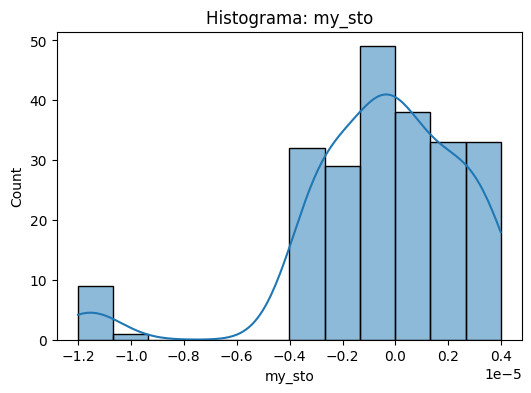

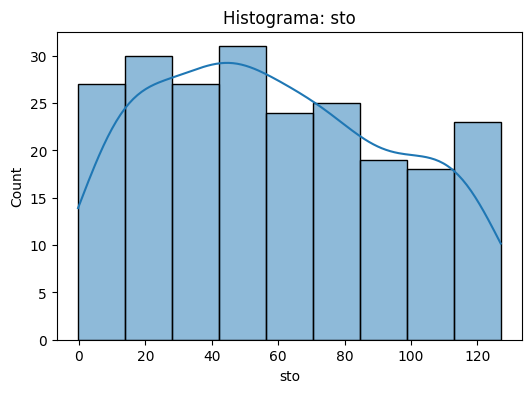

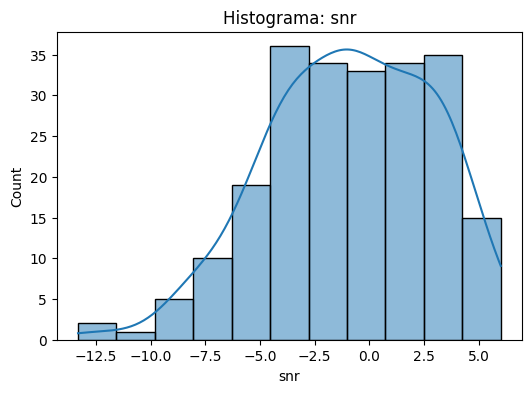

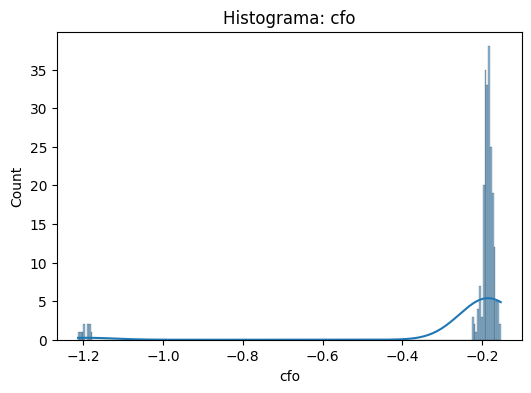

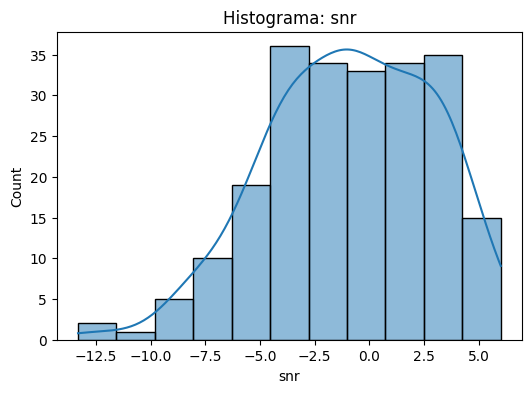

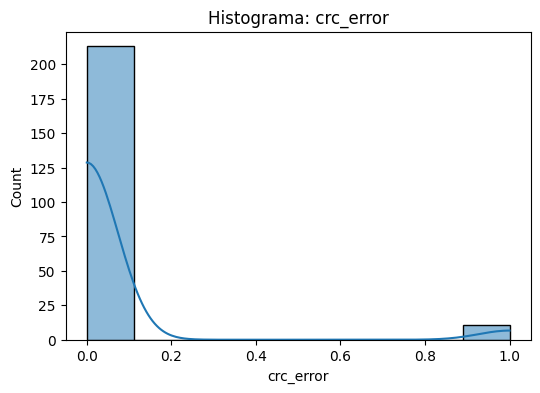

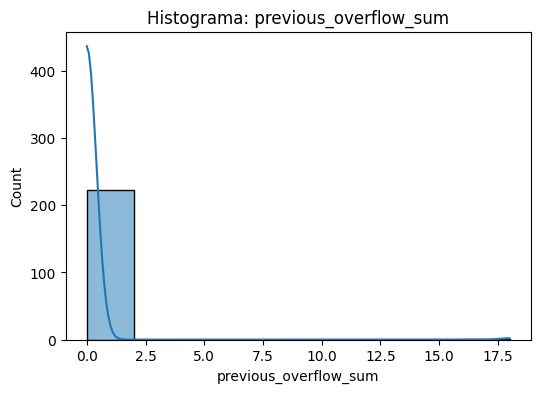

In [23]:
plot_histograma(df)

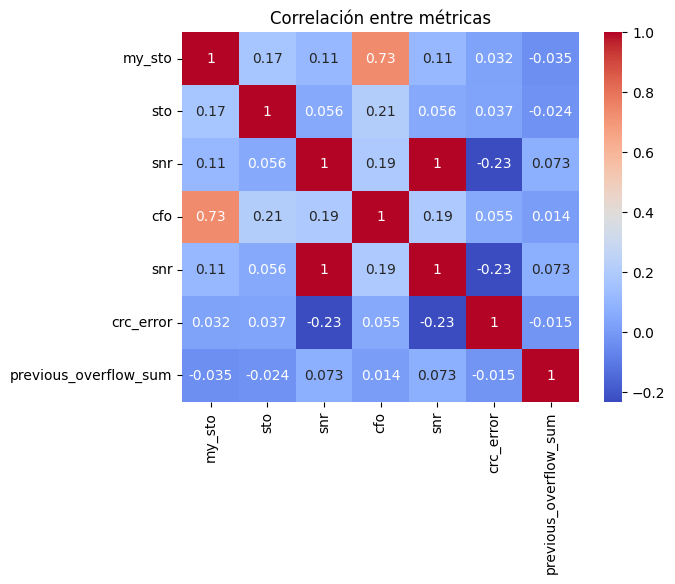

In [24]:
plot_correlacion(df)